In [12]:
import sys, os, tempfile, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import Bio.PDB as bp
import tmtools

# Add project root so we can import proteinttt utilities
PROJECT_ROOT = "/scratch/project/open-35-8/pimenol1/ProteinTTT/ProteinTTT_fresh"
sys.path.insert(0, PROJECT_ROOT)

from proteinttt.utils.structure import lddt_score, calculate_plddt

# ── Paths ──────────────────────────────────────────────────────────────
DATA_DIR       = os.path.join(PROJECT_ROOT, "data", "LL")
PDB_DIR        = os.path.join(DATA_DIR, "pdb")
PRED_TTT_DIR   = os.path.join(DATA_DIR, "predicted_structures", "ESMFold_ProteinTTT")
PRED_ESM_DIR   = os.path.join(DATA_DIR, "predicted_structures", "ESMFold")

NMR_REF_PATH   = os.path.join(PDB_DIR, "2L7B.pdb")

VARIANTS = {
    "ApoE3":      "ApoE3_A.pdb",
    "ApoE2":      "ApoE2_A.pdb",
    "ApoE4":      "ApoE4_dimer_A.pdb",
    "NMR (2L7B)": "NMR_A.pdb",
}

print("Data directory:", DATA_DIR)
print("Predicted structures (ProteinTTT):", os.listdir(PRED_TTT_DIR))
print("Predicted structures (ESMFold):",    os.listdir(PRED_ESM_DIR))

Data directory: /scratch/project/open-35-8/pimenol1/ProteinTTT/ProteinTTT_fresh/data/LL
Predicted structures (ProteinTTT): ['ApoE3_A.pdb', 'NMR_A.pdb', 'ApoE2_A.pdb', 'ApoE4_dimer_A.pdb']
Predicted structures (ESMFold): ['ApoE3_A.pdb', 'NMR_A.pdb', 'ApoE2_A.pdb', 'ApoE4_dimer_A.pdb']


# ApoE Variant Analysis — ProteinTTT vs ESMFold

## Background

**ApoE (Apolipoprotein E)** exists in three common isoforms that differ by single amino-acid substitutions at positions **112** and **158** (numbering from the mature protein start):

| Isoform | Pos 112 | Pos 158 | Notes |
|---------|---------|---------|-------|
| **ApoE3** (WT) | Cys | Arg | Reference wild-type |
| **ApoE2** | Cys | **Cys** (R→C) | Associated with type III hyperlipoproteinemia |
| **ApoE4** | **Arg** (C→R) | Arg | Major risk factor for Alzheimer's disease |
| **NMR (2L7B)** | Cys | Arg | 5-point mutant to prevent oligomerisation (PDB: 2L7B) |

The **NMR construct** (PDB 2L7B) carries 5 additional mutations in the C-terminal domain (F257A, W264R, V269A, L279Q, V283E) plus an N-terminal His₈-tag, designed to keep the protein monomeric for NMR studies.

### Key questions
1. Does ProteinTTT produce **different** structures for ApoE2 / E3 / E4? (AlphaFold often gives nearly identical folds.)
2. How well does the NMR-construct prediction match the **experimental** 2L7B structure?
3. Does the ApoE3 (WT) prediction **differ** from the NMR structure (expected, since the NMR construct is artificially stabilised)?

In [13]:
# ── Helper functions ────────────────────────────────────────────────────

AA3_TO_AA1 = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F',
    'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L',
    'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R',
    'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y',
}

def get_ca_coords_and_seq(pdb_path, model_idx=0):
    """Extract Cα coordinates and one-letter sequence from a PDB file."""
    parser = bp.PDBParser(QUIET=True)
    structure = parser.get_structure("s", pdb_path)
    model = structure[model_idx]
    coords, seq = [], []
    for chain in model:
        for res in chain:
            if not bp.is_aa(res, standard=True):
                continue
            if res.has_id("CA"):
                coords.append(res["CA"].get_coord())
                seq.append(AA3_TO_AA1.get(res.get_resname(), "X"))
    return np.array(coords, dtype=np.float64), "".join(seq)


def compute_tm_score(pdb1, pdb2, model_idx1=0, model_idx2=0):
    """Compute TM-score between two PDB files using tmtools (pure Python).
    Returns (tm1, tm2, rmsd) where tm1/tm2 are normalised by chain 1/2 length."""
    c1, s1 = get_ca_coords_and_seq(pdb1, model_idx1)
    c2, s2 = get_ca_coords_and_seq(pdb2, model_idx2)
    res = tmtools.tm_align(c1, c2, s1, s2)
    return res.tm_norm_chain1, res.tm_norm_chain2, res.rmsd


def compute_lddt_aligned(pdb_ref, pdb_model, ref_model_idx=0, model_model_idx=0):
    """Compute lDDT using sequence alignment to handle different numbering.
    Writes temporary PDBs with only the first model and matching residue numbers."""
    c_ref, s_ref = get_ca_coords_and_seq(pdb_ref, ref_model_idx)
    c_mdl, s_mdl = get_ca_coords_and_seq(pdb_model, model_model_idx)

    # Use tmtools alignment to find residue correspondence
    res = tmtools.tm_align(c_mdl, c_ref, s_mdl, s_ref)
    aln1, aln2 = res.seqxA, res.seqyA  # aligned sequences with gaps

    # Build matched coordinate arrays
    idx1, idx2 = 0, 0
    ref_coords, mdl_coords = [], []
    for a, b in zip(aln1, aln2):
        if a != "-" and b != "-":
            mdl_coords.append(c_mdl[idx1])
            ref_coords.append(c_ref[idx2])
        if a != "-":
            idx1 += 1
        if b != "-":
            idx2 += 1

    ref_arr = np.array(ref_coords)
    mdl_arr = np.array(mdl_coords)
    n = len(ref_arr)

    # lDDT computation on aligned residues
    cutoff = 15.0
    thresholds = (0.5, 1.0, 2.0, 4.0)
    D_ref = np.linalg.norm(ref_arr[:, None, :] - ref_arr[None, :, :], axis=-1)
    D_mdl = np.linalg.norm(mdl_arr[:, None, :] - mdl_arr[None, :, :], axis=-1)
    neighbor_mask = (D_ref <= cutoff) & (~np.eye(n, dtype=bool))

    per_res = []
    for i in range(n):
        nbrs = np.where(neighbor_mask[i])[0]
        if len(nbrs) == 0:
            continue
        delta = np.abs(D_ref[i, nbrs] - D_mdl[i, nbrs])
        score = np.mean([(delta < t).mean() for t in thresholds])
        per_res.append(score)

    return float(np.mean(per_res)) if per_res else float("nan")


def save_first_model(pdb_path, out_path):
    """Write only the first model of a multi-model PDB to a new file."""
    with open(pdb_path) as fin, open(out_path, "w") as fout:
        inside_model = False
        for line in fin:
            if line.startswith("MODEL"):
                model_num = int(line.split()[1])
                if model_num == 1:
                    inside_model = True
                    continue  # skip the MODEL line itself
                else:
                    break  # done after first model
            if line.startswith("ENDMDL"):
                break
            if inside_model or not any(line.startswith(x) for x in ("MODEL", "ENDMDL")):
                if line.startswith("ATOM") or line.startswith("TER") or line.startswith("HEADER"):
                    fout.write(line)
        fout.write("END\n")

# Save first model of 2L7B for lDDT calculations with same-numbering structures
NMR_REF_MODEL1 = os.path.join(PDB_DIR, "2L7B_model1.pdb")
save_first_model(NMR_REF_PATH, NMR_REF_MODEL1)
c, s = get_ca_coords_and_seq(NMR_REF_MODEL1)
print(f"2L7B model 1: {len(s)} residues, seq[:15] = {s[:15]}")
print("Helper functions ready.")

2L7B model 1: 299 residues, seq[:15] = KVEQAVETEPEPELR
Helper functions ready.


## 1. Sequence comparison — identify the mutations

In [14]:
# Load the sequences used for prediction
df_summary = pd.read_csv(os.path.join(DATA_DIR, "summary.csv"))
display(df_summary[["pdb_id", "length"]])

seqs = dict(zip(df_summary["pdb_id"], df_summary["sequence"]))

# ── Identify ApoE2 / E3 / E4 mutations ────────────────────────────────
def align_and_diff(ref, alt, label):
    """Find mutations/indels between two sequences using simple gap scanning."""
    if len(ref) == len(alt):
        diffs = [(i + 1, r, a) for i, (r, a) in enumerate(zip(ref, alt)) if r != a]
        for pos, r, a in diffs:
            print(f"  {label}: position {pos}: {r} → {a}")
        return

    # Different lengths → find best single-gap alignment
    print(f"  {label}: length differs ({len(ref)} vs {len(alt)}), trying gapped alignment…")
    longer, shorter = (ref, alt) if len(ref) > len(alt) else (alt, ref)
    gap_len = len(longer) - len(shorter)
    best_pos, best_mm = 0, len(longer)
    for gap_start in range(len(shorter) + 1):
        # Insert gap(s) in shorter at position gap_start
        aligned_short = shorter[:gap_start] + "-" * gap_len + shorter[gap_start:]
        mm = sum(1 for a, b in zip(longer, aligned_short) if a != b and b != "-")
        if mm < best_mm:
            best_mm, best_pos = mm, gap_start

    aligned_short = shorter[:best_pos] + "-" * gap_len + shorter[best_pos:]
    print(f"    Best alignment: gap at position {best_pos + 1} in {label}, {best_mm} substitution(s)")
    print(f"    Ref: …{ref[max(0,best_pos-5):best_pos+gap_len+5]}…")
    print(f"    Alt: …{alt[max(0,best_pos-5):best_pos+5]}…  (deletion of {gap_len} residue(s))")
    for i, (a, b) in enumerate(zip(longer, aligned_short)):
        if a != b and b != "-":
            print(f"    Substitution at ref position {i + 1}: {a} → {b}")

print("\n=== ApoE isoform mutations (E3 as reference) ===")
for name in ["ApoE2", "ApoE4_dimer"]:
    ref, alt = seqs["ApoE3"], seqs[name]
    label = "ApoE2" if "2" in name else "ApoE4"
    align_and_diff(ref, alt, label)

# ── NMR construct mutations vs ApoE3 ──────────────────────────────────
print("\n=== NMR construct (2L7B) mutations vs ApoE3 ===")
nmr_seq = seqs["NMR"]
e3_seq = seqs["ApoE3"]
# NMR has 8-His tag at start; compare from residue 9 of NMR to residue 1 of E3
his_tag_len = 0
while his_tag_len < len(nmr_seq) and nmr_seq[his_tag_len] == "H":
    his_tag_len += 1
print(f"  His-tag length: {his_tag_len} residues")

nmr_core = nmr_seq[his_tag_len:]
diffs_nmr = [(i + 1, e, n) for i, (e, n) in enumerate(zip(e3_seq, nmr_core)) if e != n]
print(f"  Mutations relative to ApoE3 (after His-tag):")
for pos, e3_aa, nmr_aa in diffs_nmr:
    print(f"    Position {pos}: {e3_aa} → {nmr_aa}")

,pdb_id,length
0,ApoE3,299
1,ApoE2,298
2,ApoE4_dimer,299
3,NMR,0



=== ApoE isoform mutations (E3 as reference) ===
  ApoE2: length differs (299 vs 298), trying gapped alignment…
    Best alignment: gap at position 189 in ApoE2, 0 substitution(s)
    Ref: …LVEQGRVRAAT…
    Alt: …LVEQGVRAAT…  (deletion of 1 residue(s))
  ApoE4: position 112: C → R

=== NMR construct (2L7B) mutations vs ApoE3 ===
  His-tag length: 8 residues
  Mutations relative to ApoE3 (after His-tag):
    Position 257: F → A
    Position 264: W → R
    Position 269: V → A
    Position 279: L → Q
    Position 287: V → E


## 2. pLDDT comparison — ESMFold vs ProteinTTT

,Variant,pLDDT (ProteinTTT),pLDDT (ESMFold),Δ pLDDT (TTT − ESM)
0,ApoE3,78.36,77.52,0.84
1,ApoE2,77.31,76.96,0.35
2,ApoE4,77.57,77.05,0.52
3,NMR (2L7B),77.38,76.84,0.54


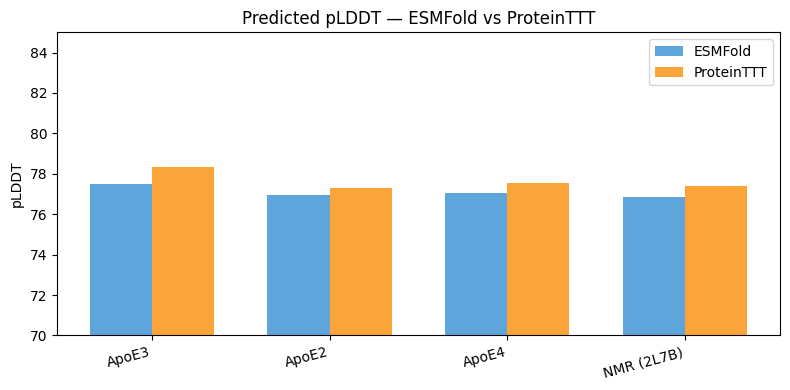

In [15]:
# Compute pLDDT for every predicted structure
rows = []
for variant_label, pdb_file in VARIANTS.items():
    ttt_path = os.path.join(PRED_TTT_DIR, pdb_file)
    esm_path = os.path.join(PRED_ESM_DIR, pdb_file)

    plddt_ttt = calculate_plddt(ttt_path)
    plddt_esm = calculate_plddt(esm_path)
    rows.append({
        "Variant": variant_label,
        "pLDDT (ProteinTTT)": round(plddt_ttt, 2),
        "pLDDT (ESMFold)":    round(plddt_esm, 2),
        "Δ pLDDT (TTT − ESM)": round(plddt_ttt - plddt_esm, 2),
    })

df_plddt = pd.DataFrame(rows)
display(df_plddt)

# Bar chart
fig, ax = plt.subplots(figsize=(8, 4))
x = np.arange(len(df_plddt))
w = 0.35
ax.bar(x - w/2, df_plddt["pLDDT (ESMFold)"],    w, label="ESMFold", color="#5DA5DA")
ax.bar(x + w/2, df_plddt["pLDDT (ProteinTTT)"], w, label="ProteinTTT", color="#FAA43A")
ax.set_xticks(x)
ax.set_xticklabels(df_plddt["Variant"], rotation=15, ha="right")
ax.set_ylabel("pLDDT")
ax.set_title("Predicted pLDDT — ESMFold vs ProteinTTT")
ax.legend()
ax.set_ylim(70, 85)
plt.tight_layout()
plt.show()

## 3. Pairwise structural comparison — do E2, E3, E4 differ?

If ProteinTTT captures the effect of single-point mutations, we expect TM-scores < 1.0 and lDDT < 1.0 between variants. AlphaFold typically produces nearly identical structures for all three isoforms.

In [16]:
# ── Pairwise TM-score & lDDT between all four ProteinTTT predictions ───
isoform_labels = list(VARIANTS.keys())
n = len(isoform_labels)

tm_matrix = np.ones((n, n))
lddt_matrix = np.ones((n, n))
rmsd_matrix = np.zeros((n, n))

for i, j in itertools.combinations(range(n), 2):
    pdb_i = os.path.join(PRED_TTT_DIR, VARIANTS[isoform_labels[i]])
    pdb_j = os.path.join(PRED_TTT_DIR, VARIANTS[isoform_labels[j]])

    tm1, tm2, rmsd = compute_tm_score(pdb_i, pdb_j)
    lddt_val = compute_lddt_aligned(pdb_i, pdb_j)

    tm_avg = (tm1 + tm2) / 2
    tm_matrix[i, j] = tm_matrix[j, i] = tm_avg
    lddt_matrix[i, j] = lddt_matrix[j, i] = lddt_val
    rmsd_matrix[i, j] = rmsd_matrix[j, i] = rmsd

    print(f"{isoform_labels[i]:12s} vs {isoform_labels[j]:12s}  "
          f"TM={tm_avg:.4f}  lDDT={lddt_val:.4f}  RMSD={rmsd:.2f} Å")

# ── Same thing for ESMFold baseline ───────────────────────────────────
print("\n--- ESMFold (baseline, no TTT) ---")
tm_matrix_esm = np.ones((n, n))
lddt_matrix_esm = np.ones((n, n))

for i, j in itertools.combinations(range(n), 2):
    pdb_i = os.path.join(PRED_ESM_DIR, VARIANTS[isoform_labels[i]])
    pdb_j = os.path.join(PRED_ESM_DIR, VARIANTS[isoform_labels[j]])
    tm1, tm2, rmsd = compute_tm_score(pdb_i, pdb_j)
    lddt_val = compute_lddt_aligned(pdb_i, pdb_j)
    tm_avg = (tm1 + tm2) / 2
    tm_matrix_esm[i, j] = tm_matrix_esm[j, i] = tm_avg
    lddt_matrix_esm[i, j] = lddt_matrix_esm[j, i] = lddt_val
    print(f"{isoform_labels[i]:12s} vs {isoform_labels[j]:12s}  "
          f"TM={tm_avg:.4f}  lDDT={lddt_val:.4f}  RMSD={rmsd:.2f} Å")

ApoE3        vs ApoE2         TM=0.9656  lDDT=0.9848  RMSD=1.27 Å
ApoE3        vs ApoE4         TM=0.9913  lDDT=0.9916  RMSD=0.61 Å
ApoE3        vs NMR (2L7B)    TM=0.9626  lDDT=0.9844  RMSD=1.08 Å
ApoE2        vs ApoE4         TM=0.9524  lDDT=0.9648  RMSD=1.59 Å
ApoE2        vs NMR (2L7B)    TM=0.9399  lDDT=0.9697  RMSD=1.48 Å
ApoE4        vs NMR (2L7B)    TM=0.9646  lDDT=0.9796  RMSD=1.16 Å

--- ESMFold (baseline, no TTT) ---
ApoE3        vs ApoE2         TM=0.9455  lDDT=0.9655  RMSD=1.78 Å
ApoE3        vs ApoE4         TM=0.9933  lDDT=0.9900  RMSD=0.55 Å
ApoE3        vs NMR (2L7B)    TM=0.9327  lDDT=0.9685  RMSD=1.30 Å
ApoE2        vs ApoE4         TM=0.9494  lDDT=0.9698  RMSD=1.70 Å
ApoE2        vs NMR (2L7B)    TM=0.9202  lDDT=0.9564  RMSD=1.86 Å
ApoE4        vs NMR (2L7B)    TM=0.9303  lDDT=0.9671  RMSD=1.45 Å


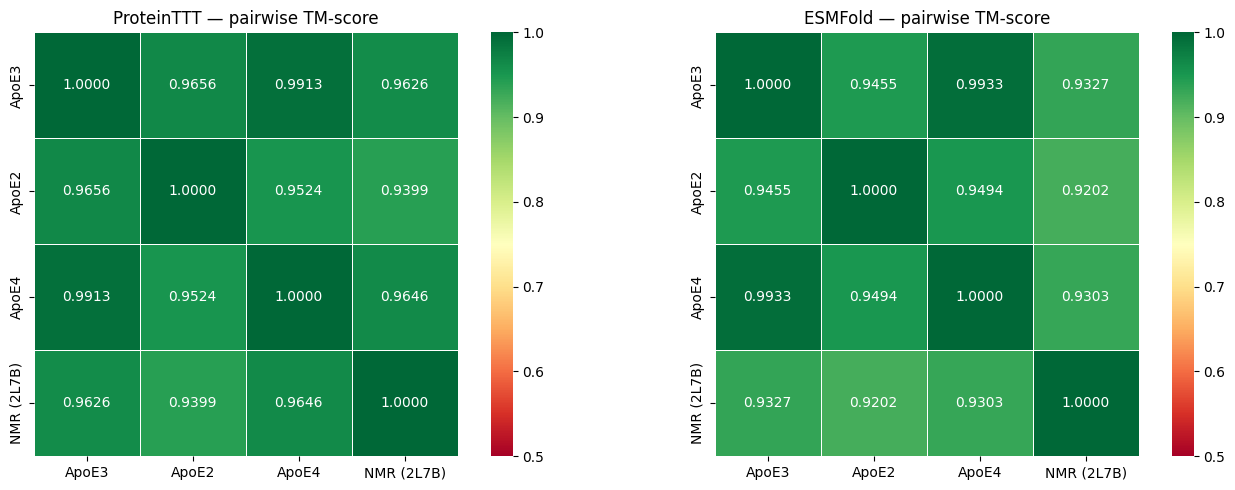

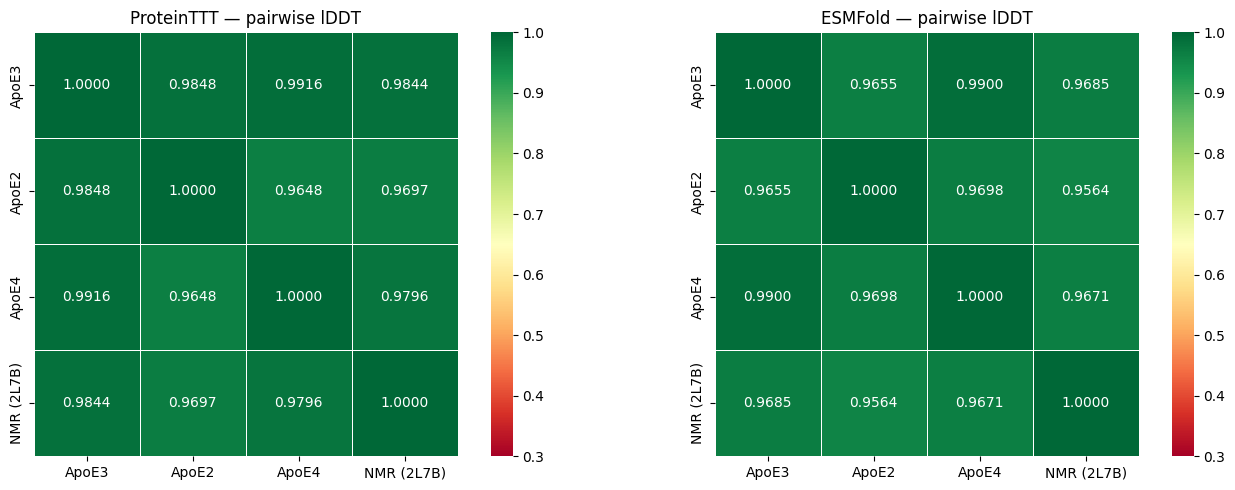

In [17]:
# ── Heatmaps: TM-score pairwise matrices ──────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, mat, title in [
    (axes[0], tm_matrix,     "ProteinTTT — pairwise TM-score"),
    (axes[1], tm_matrix_esm, "ESMFold — pairwise TM-score"),
]:
    sns.heatmap(
        mat, annot=True, fmt=".4f", xticklabels=isoform_labels,
        yticklabels=isoform_labels, cmap="RdYlGn", vmin=0.5, vmax=1.0,
        ax=ax, square=True, linewidths=0.5,
    )
    ax.set_title(title)

plt.tight_layout()
plt.show()

# ── Heatmaps: lDDT pairwise matrices ─────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, mat, title in [
    (axes[0], lddt_matrix,     "ProteinTTT — pairwise lDDT"),
    (axes[1], lddt_matrix_esm, "ESMFold — pairwise lDDT"),
]:
    sns.heatmap(
        mat, annot=True, fmt=".4f", xticklabels=isoform_labels,
        yticklabels=isoform_labels, cmap="RdYlGn", vmin=0.3, vmax=1.0,
        ax=ax, square=True, linewidths=0.5,
    )
    ax.set_title(title)

plt.tight_layout()
plt.show()

## 4. Comparison to experimental NMR structure (PDB 2L7B)

The NMR PDB has 20 conformational models. We use model 1 as the reference.

**Expected results:**
- **NMR prediction** should match the experimental 2L7B structure well (same sequence).
- **ApoE3 (WT) prediction** should differ from 2L7B because the NMR construct has 5 stabilising mutations and a His-tag that alter the structure.

In [18]:
# ── Compare all predictions against the experimental 2L7B structure ────
# 2L7B has 20 NMR models; we compare against model 1.
# Note: 2L7B residues 1-299 correspond to the ApoE sequence WITHOUT the His-tag.
# The NMR predicted PDB has 307 residues (8 His + 299 ApoE).
# tmtools handles different-length sequences via structural alignment.

ref_pdb = NMR_REF_MODEL1  # first model of 2L7B (299 residues)

print("=== All predictions vs 2L7B experimental (model 1) ===\n")
rows_ref = []
for method_name, pred_dir in [("ProteinTTT", PRED_TTT_DIR), ("ESMFold", PRED_ESM_DIR)]:
    for variant_label, pdb_file in VARIANTS.items():
        pred_path = os.path.join(pred_dir, pdb_file)

        tm1, tm2, rmsd = compute_tm_score(pred_path, ref_pdb)
        lddt_val = compute_lddt_aligned(ref_pdb, pred_path)

        rows_ref.append({
            "Method":  method_name,
            "Variant": variant_label,
            "TM-score (norm pred)": round(tm1, 4),
            "TM-score (norm 2L7B)": round(tm2, 4),
            "lDDT":   round(lddt_val, 4),
            "RMSD (Å)": round(rmsd, 2),
        })
        print(f"  {method_name:12s} | {variant_label:12s} → TM={tm2:.4f}  lDDT={lddt_val:.4f}  RMSD={rmsd:.2f} Å")

df_ref = pd.DataFrame(rows_ref)
display(df_ref)

=== All predictions vs 2L7B experimental (model 1) ===

  ProteinTTT   | ApoE3        → TM=0.4289  lDDT=0.6839  RMSD=3.44 Å
  ProteinTTT   | ApoE2        → TM=0.4286  lDDT=0.6846  RMSD=3.43 Å
  ProteinTTT   | ApoE4        → TM=0.4280  lDDT=0.6854  RMSD=3.42 Å
  ProteinTTT   | NMR (2L7B)   → TM=0.4307  lDDT=0.6766  RMSD=3.58 Å
  ESMFold      | ApoE3        → TM=0.4265  lDDT=0.6886  RMSD=3.25 Å
  ESMFold      | ApoE2        → TM=0.4259  lDDT=0.6990  RMSD=3.16 Å
  ESMFold      | ApoE4        → TM=0.4235  lDDT=0.7031  RMSD=3.15 Å
  ESMFold      | NMR (2L7B)   → TM=0.4277  lDDT=0.6896  RMSD=3.37 Å


,Method,Variant,TM-score (norm pred),TM-score (norm 2L7B),lDDT,RMSD (Å)
0,ProteinTTT,ApoE3,0.4289,0.4289,0.6839,3.44
1,ProteinTTT,ApoE2,0.4299,0.4286,0.6846,3.43
2,ProteinTTT,ApoE4,0.4280,0.4280,0.6854,3.42
3,ProteinTTT,NMR (2L7B),0.4207,0.4307,0.6766,3.58
4,ESMFold,ApoE3,0.4265,0.4265,0.6886,3.25
5,ESMFold,ApoE2,0.4272,0.4259,0.6990,3.16
6,ESMFold,ApoE4,0.4235,0.4235,0.7031,3.15
7,ESMFold,NMR (2L7B),0.4177,0.4277,0.6896,3.37


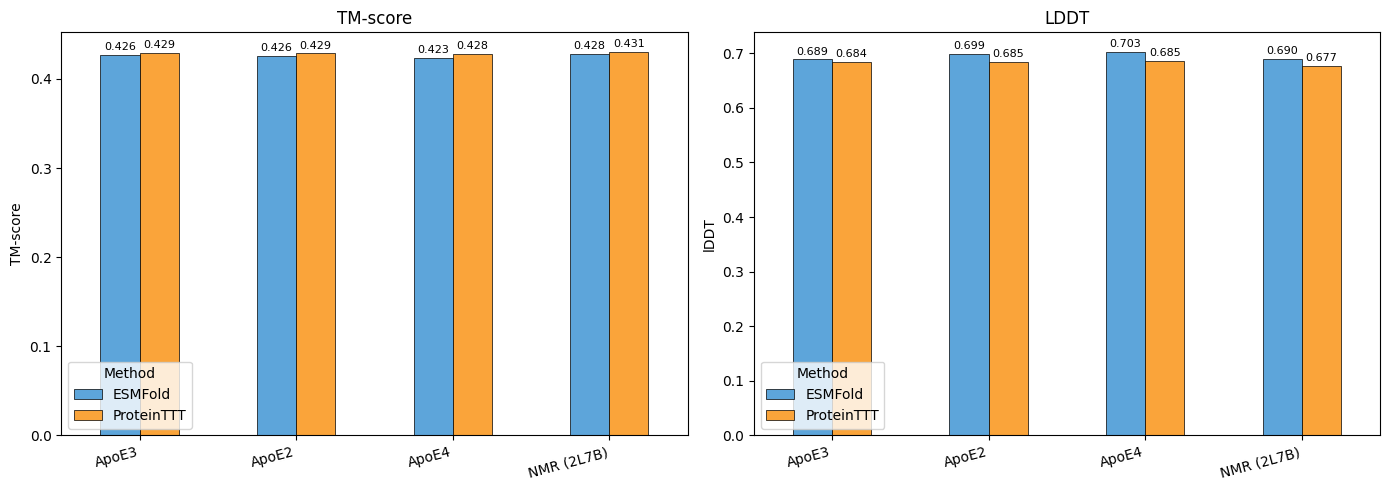

In [22]:
# ── Grouped bar chart: TM-score & lDDT vs 2L7B ──────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, metric, title in [
    (axes[0], "TM-score (norm 2L7B)", "TM-score"),
    (axes[1], "lDDT",                  "LDDT"),
]:
    df_pivot = df_ref.pivot(index="Variant", columns="Method", values=metric)
    df_pivot = df_pivot.reindex(list(VARIANTS.keys()))  # keep order
    df_pivot.plot(kind="bar", ax=ax, color=["#5DA5DA", "#FAA43A"], edgecolor="k", linewidth=0.5)
    ax.set_title(title)
    ax.set_ylabel(metric.split(" (")[0])
    ax.set_xlabel("")
    ax.legend(title="Method")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")
    # add value labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt="%.3f", fontsize=8, padding=2)

plt.tight_layout()
plt.show()

## 5. ProteinTTT vs ESMFold — how much does TTT change the structure?

Compare each variant's ESMFold prediction against its ProteinTTT prediction to quantify how much test-time training modifies the fold.

In [20]:
# ── ESMFold vs ProteinTTT for each variant ────────────────────────────
print("=== ESMFold vs ProteinTTT (same variant) ===\n")
rows_ttt_vs_esm = []
for variant_label, pdb_file in VARIANTS.items():
    ttt_path = os.path.join(PRED_TTT_DIR, pdb_file)
    esm_path = os.path.join(PRED_ESM_DIR, pdb_file)

    tm1, tm2, rmsd = compute_tm_score(esm_path, ttt_path)
    lddt_val = compute_lddt_aligned(esm_path, ttt_path)

    rows_ttt_vs_esm.append({
        "Variant": variant_label,
        "TM-score": round((tm1 + tm2) / 2, 4),
        "lDDT": round(lddt_val, 4),
        "RMSD (Å)": round(rmsd, 2),
    })
    print(f"  {variant_label:12s}  TM={(tm1+tm2)/2:.4f}  lDDT={lddt_val:.4f}  RMSD={rmsd:.2f} Å")

df_ttt_esm = pd.DataFrame(rows_ttt_vs_esm)
display(df_ttt_esm)

=== ESMFold vs ProteinTTT (same variant) ===

  ApoE3         TM=0.9305  lDDT=0.9598  RMSD=2.13 Å
  ApoE2         TM=0.9017  lDDT=0.9524  RMSD=2.59 Å
  ApoE4         TM=0.9335  lDDT=0.9550  RMSD=2.36 Å
  NMR (2L7B)    TM=0.9352  lDDT=0.9598  RMSD=1.49 Å


,Variant,TM-score,lDDT,RMSD (Å)
0,ApoE3,0.9305,0.9598,2.13
1,ApoE2,0.9017,0.9524,2.59
2,ApoE4,0.9335,0.9550,2.36
3,NMR (2L7B),0.9352,0.9598,1.49


## 6. Summary

In [21]:
# ── Summary table ─────────────────────────────────────────────────────
print("=" * 70)
print("SUMMARY OF RESULTS")
print("=" * 70)

# Q1: Do E2, E3, E4 differ?
e2e3e4_labels = ["ApoE3", "ApoE2", "ApoE4"]
e2e3e4_idx = [isoform_labels.index(l) for l in e2e3e4_labels]
ttt_pairs = [(i, j) for i, j in itertools.combinations(e2e3e4_idx, 2)]
esm_pairs = ttt_pairs

print("\n1. Pairwise structural differences among ApoE2/E3/E4:")
print(f"   {'Pair':<20s} {'ProteinTTT TM':>14s} {'ESMFold TM':>12s} {'ProteinTTT lDDT':>16s} {'ESMFold lDDT':>14s}")
for i, j in ttt_pairs:
    pair_name = f"{isoform_labels[i]} vs {isoform_labels[j]}"
    print(f"   {pair_name:<20s} {tm_matrix[i,j]:>14.4f} {tm_matrix_esm[i,j]:>12.4f} "
          f"{lddt_matrix[i,j]:>16.4f} {lddt_matrix_esm[i,j]:>14.4f}")

print(f"\n   → ProteinTTT {'DOES' if any(tm_matrix[i,j] < 0.99 for i,j in ttt_pairs) else 'does NOT'} "
      f"produce distinguishable structures for ApoE2/E3/E4.")
print(f"   → ESMFold    {'DOES' if any(tm_matrix_esm[i,j] < 0.99 for i,j in ttt_pairs) else 'does NOT'} "
      f"produce distinguishable structures for ApoE2/E3/E4.")

# Q2: NMR prediction vs 2L7B
nmr_ttt = df_ref[(df_ref["Method"] == "ProteinTTT") & (df_ref["Variant"] == "NMR (2L7B)")].iloc[0]
nmr_esm = df_ref[(df_ref["Method"] == "ESMFold") & (df_ref["Variant"] == "NMR (2L7B)")].iloc[0]

print(f"\n2. NMR construct prediction vs 2L7B experimental:")
print(f"   ProteinTTT: TM={nmr_ttt['TM-score (norm 2L7B)']:.4f}  lDDT={nmr_ttt['lDDT']:.4f}  RMSD={nmr_ttt['RMSD (Å)']:.2f} Å")
print(f"   ESMFold:    TM={nmr_esm['TM-score (norm 2L7B)']:.4f}  lDDT={nmr_esm['lDDT']:.4f}  RMSD={nmr_esm['RMSD (Å)']:.2f} Å")

# Q3: ApoE3 vs 2L7B (should differ)
e3_ttt = df_ref[(df_ref["Method"] == "ProteinTTT") & (df_ref["Variant"] == "ApoE3")].iloc[0]
e3_esm = df_ref[(df_ref["Method"] == "ESMFold") & (df_ref["Variant"] == "ApoE3")].iloc[0]

print(f"\n3. ApoE3 (WT) prediction vs 2L7B (should differ due to stabilising mutations):")
print(f"   ProteinTTT: TM={e3_ttt['TM-score (norm 2L7B)']:.4f}  lDDT={e3_ttt['lDDT']:.4f}  RMSD={e3_ttt['RMSD (Å)']:.2f} Å")
print(f"   ESMFold:    TM={e3_esm['TM-score (norm 2L7B)']:.4f}  lDDT={e3_esm['lDDT']:.4f}  RMSD={e3_esm['RMSD (Å)']:.2f} Å")

nmr_better = nmr_ttt['TM-score (norm 2L7B)'] > e3_ttt['TM-score (norm 2L7B)']
print(f"\n   → NMR construct prediction is {'CLOSER' if nmr_better else 'NOT closer'} to 2L7B than ApoE3 prediction (as expected).")

print("\n" + "=" * 70)

SUMMARY OF RESULTS

1. Pairwise structural differences among ApoE2/E3/E4:
   Pair                  ProteinTTT TM   ESMFold TM  ProteinTTT lDDT   ESMFold lDDT
   ApoE3 vs ApoE2               0.9656       0.9455           0.9848         0.9655
   ApoE3 vs ApoE4               0.9913       0.9933           0.9916         0.9900
   ApoE2 vs ApoE4               0.9524       0.9494           0.9648         0.9698

   → ProteinTTT DOES produce distinguishable structures for ApoE2/E3/E4.
   → ESMFold    DOES produce distinguishable structures for ApoE2/E3/E4.

2. NMR construct prediction vs 2L7B experimental:
   ProteinTTT: TM=0.4307  lDDT=0.6766  RMSD=3.58 Å
   ESMFold:    TM=0.4277  lDDT=0.6896  RMSD=3.37 Å

3. ApoE3 (WT) prediction vs 2L7B (should differ due to stabilising mutations):
   ProteinTTT: TM=0.4289  lDDT=0.6839  RMSD=3.44 Å
   ESMFold:    TM=0.4265  lDDT=0.6886  RMSD=3.25 Å

   → NMR construct prediction is CLOSER to 2L7B than ApoE3 prediction (as expected).

